In [1]:
projPath_load='/home/alvaro/notebook/jupyterenv/bin/TFM/DATA/dfA_n2_zone_aturat_index.csv'

In [2]:
projPath_save='/home/alvaro/notebook/jupyterenv/bin/TFM/DATA/'

In [3]:
month = '202206'
darsena = '_DM'

In [4]:
buffer_basin = 20 #m
buffer_dock = 30 #m
buffer_basin1 = 150 #m

min_points = 10

In [5]:
import numpy as np
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt

In [6]:
%matplotlib notebook

In [7]:
moll_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/MollsDarsenaMorrot_noTalo.shp')
dm_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/DarsenaMorrot.shp')

In [8]:
dm_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
dm_buffer = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin).to_crs(4326))
dm_buffer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
dm_buffer_z2 = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin1).to_crs(4326))
dm_buffer_z2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
moll_buffer = gpd.GeoDataFrame(geometry = moll_map.to_crs(32631).buffer(buffer_dock, cap_style = 2,join_style = 2).to_crs(4326))

<IPython.core.display.Javascript object>


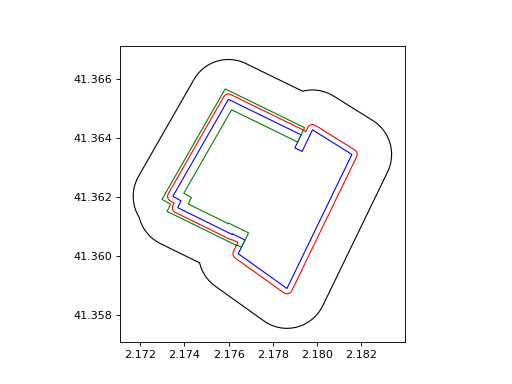

<AxesSubplot:>

In [12]:
fig, ax = plt.subplots()
dm_map.plot(ax = ax, fc = 'none', ec = 'blue')
dm_buffer.plot(ax = ax, fc = 'none', ec = 'red')
moll_buffer.plot(ax = ax, fc = 'none', ec = 'green')
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')

# Load Data

In [13]:
dfA_n2=pd.read_csv(projPath_load)

In [14]:
len(dfA_n2)

57339

ADD NEW COLUMN

In [15]:
dfA_n2['real_atur']=0

In [16]:
dfA_n2.head()

time_stamp       mmsi  status  turn  speed      lon       lat  \
0  2022-06-01 01:03:59  247383500       0  -6.0   34.0  2.17667  41.35834   
1  2022-06-01 01:04:10  247383500       0  -7.0   33.0  2.17678  41.35849   
2  2022-06-01 01:04:20  247383500       0  -7.0   33.0  2.17686  41.35864   
3  2022-06-01 01:04:30  247383500       0  -8.0   33.0  2.17695  41.35878   
4  2022-06-01 01:04:40  247383500       0  -9.0   32.0  2.17704  41.35892   

   course  heading         day  ... draught  to_bow  to_stern  to_starboard  \
0    26.1     25.0  2022-06-01  ...     6.6   116.0     122.0          27.0   
1    25.9     25.0  2022-06-01  ...     6.6   116.0     122.0          27.0   
2    25.5     24.0  2022-06-01  ...     6.6   116.0     122.0          27.0   
3    25.3     24.0  2022-06-01  ...     6.6   116.0     122.0          27.0   
4    25.1     23.0  2022-06-01  ...     6.6   116.0     122.0          27.0   

   to_port      imo  zone  aturat  entsort  real_atur  
0      7.0  9859557     2     NaN      NaN          0  
1      7.0  9859557     2     NaN      NaN          0  
2      7.0  9859557     2     NaN      NaN          0  
3      7.0  9859557     2     NaN      NaN          0  
4      7.0  9859557     2     NaN      NaN          0  

[5 rows x 22 columns]

# FUNCTIONS DEFINITION

Normal case

In [17]:
def realparado (dft):
    df=dft.copy()
    df['parado'] = (df['speed'] == 0)
    df['consecutivos'] = (df['parado'] != df['parado'].shift()).cumsum()
    dif = df.loc[df['speed']==0].groupby('consecutivos')
    grupos = dif['time_stamp'].apply(lambda x: pd.to_datetime(x.iloc[-1]) - pd.to_datetime(x.iloc[0]))
    grupos_filtrados = grupos[grupos >= pd.Timedelta(minutes = 5)]
    indices = grupos_filtrados.index.values
    for consecutivo in indices:
        df.loc[df['consecutivos'] == consecutivo, 'real_atur'] = 1
    dft['real_atur'] = df['real_atur']
    dft['real_atur'] = medfilt(df['real_atur'], kernel_size = 57)

Case when GPS signal error appears

In [18]:
def realparado1 (dft):
    df=dft.copy()
    df['speed_window'] = df['speed'].rolling(window=5).mean()
    df['parado'] = (df['speed_window'] < 1)
    df['consecutivos'] = (df['parado'] != df['parado'].shift()).cumsum()
    dif = df.loc[df['speed_window']<1].groupby('consecutivos')
    grupos = dif['time_stamp'].apply(lambda x: pd.to_datetime(x.iloc[-1]) - pd.to_datetime(x.iloc[0]))
    grupos_filtrados = grupos[grupos >= pd.Timedelta(minutes = 5)]
    indices = grupos_filtrados.index.values
    for consecutivo in indices:
        df.loc[df['consecutivos'] == consecutivo, 'real_atur'] = 1
    dft['real_atur'] = df['real_atur']
    dft['real_atur'] = medfilt(df['real_atur'], kernel_size = 87)

Final Function

In [19]:
def realparado2 (df):
    realparado(df)
    l1 = len(df['real_atur'])
    l2 = len(df.loc[df['real_atur']==1,:])
    l3 = len(df.loc[df['speed']==1,:])/len(df['speed'])
    if (l2/l1 < 0.3) or (l3 > 0.12):
        df['real_atur']=0
        realparado1(df)
    else:
        pass

In [20]:
def realparado3 (dft):
    df = dft.loc[(dft['entsort']=='ent')|(dft['entsort']=='sort') ,:].copy()
    dfAt = dft.copy()
    for elm in range (0, df.shape[0], 2):
        r1=df.index[elm]
        r2=df.index[elm+1]
        dt = dfAt.loc[r1:r2,:].copy()
        realparado3(dt)
        tt = dt.loc[dt['real_atur']==1,:].index
        dfAt.loc[tt,['real_atur']]=1

In [21]:
def realparado4 (dfA1):
    df = dfA1.loc[(dfA1['entsort']=='ent')|(dfA1['entsort']=='sort') ,:].copy()
    dfAt = dfA1.copy()
    for elm in range (0, df.shape[0], 2):
        r1=df.index[elm]
        r2=df.index[elm+1]
        dtt = dfAt.loc[r1:r2,:].copy()
        realparado2(dtt)
        tt = dtt.loc[dtt['real_atur']==1,:].index
        dfAt.loc[tt,['real_atur']]=1
    dfA_n2.loc[dfAt.loc[dfAt['real_atur']==1, :].index,['real_atur']]=1

Combprobation Function

In [22]:
def comp (dft):
    len(dft['speed']), len(dft.loc[dft['speed']==1,:]), len(dft.loc[dft['speed']==0,:])
    l1 = len(dft.loc[dft['speed']==1,:])/len(dft['speed'])
    l2 = len(dft.loc[dft['speed']==0,:])/len(dft['speed'])
    l3 = len(dft.loc[dft['speed']==1,:])/len(dft.loc[dft['speed']==0,:])
    l4 = len(dft.loc[dft['real_atur']==1,:])/len(dft['real_atur'])
    z = [len(dft['speed']), len(dft.loc[dft['speed']==1,:]), len(dft.loc[dft['speed']==0,:]),
    len(dft.loc[dft['speed']==1,:])/len(dft['speed']),
    len(dft.loc[dft['speed']==0,:])/len(dft['speed']),
    len(dft.loc[dft['speed']==1,:])/len(dft.loc[dft['speed']==0,:]),
    len(dft.loc[dft['real_atur']==1,:])/len(dft['real_atur'])]
    if l4 < 0.3 or l1 > 0.12:
        print ('R1')
    else:
        print ('R')
    return (z)

# GROUP BY

In [23]:
dfAmmsi=dfA_n2.groupby('mmsi')

In [24]:
dfA_n2.mmsi.unique()

array([247383500, 247383600, 247219400, 247383400, 247243600, 247383300,
       209115000, 210117000])

In [25]:
(len(dfA_n2.loc[0:57073,:]), len(dfA_n2))

(57074, 57339)

In [26]:
dfAmmsi.apply(realparado4)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

36699

# 247383500

In [26]:
dfA1=dfAmmsi.get_group(247383500)

In [32]:
def realparado4 (dfA1):
    df = dfA1.loc[(dfA1['entsort']=='ent')|(dfA1['entsort']=='sort') ,:].copy()
    dfAt = dfA1.copy()
    for elm in range (0, df.shape[0], 2):
        r1=df.index[elm]
        r2=df.index[elm+1]
        dtt = dfAt.loc[r1:r2,:].copy()
        realparado2(dtt)
        tt = dtt.loc[dtt['real_atur']==1,:].index
        dfAt.loc[tt,['real_atur']]=1
    dfA_n2.loc[dfAt.loc[dfAt['real_atur']==1, :].index,['real_atur']]=1

In [27]:
realparado4(dfA1)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

2017

In [29]:
dfA_n2.loc[dfAt.loc[dfAt['real_atur']==1, :].index,['real_atur']]=1

In [31]:
(len(dfAt), len(dfA1), len(dfAt.loc[dfAt['real_atur']==1, :]), len(dfA_n2.loc[dfA_n2['real_atur']==1,:]) )

NameError: name 'dfAt' is not defined

In [34]:
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

2017

In [79]:
dfA_n2.loc[dfAt.loc[dfAt['real_atur']==1, :].index,['real_atur']]=1

In [81]:
(len(dfA_n2.loc[dfA_n2['real_atur']==1,:]), len(dfA_n2))

(2192, 57339)

In [58]:
dfA1.real_atur.unique()

array([0, 1])

In [59]:
(len(dfA1.loc[dfA1['real_atur']==1,:]), len(dfA1))

(2016, 5890)

In [53]:
dfA1['real_atur'].describe()

count    5890.000000
mean        0.342275
std         0.474511
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: real_atur, dtype: float64

In [46]:
    df = dfA1.loc[(dfA1['entsort']=='ent')|(dfA1['entsort']=='sort') ,:].copy()
    for elm in range (0, df.shape[0], 2):
        r1=df.index[elm]
        r2=df.index[elm+1]
        print(r1,r2)

289 478
6078 6538
11994 12193
15592 15875
31014 31268
33229 33522
38562 38832
41211 41431
46755 46996
50238 50499
56708 57073


In [30]:
realparado3(dfA1)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [43]:
dfA1.loc[289:478,:].head()

time_stamp  status  turn  speed      lon       lat  course  \
289  2022-06-01 01:27:50       0  -7.0    2.0  2.17732  41.36455     9.4   
290  2022-06-01 01:27:58       0  -7.0    2.0  2.17732  41.36455     8.5   
291  2022-06-01 01:28:09       0  -6.0    2.0  2.17732  41.36456     9.1   
292  2022-06-01 01:28:19       0  -1.0    1.0  2.17732  41.36457     9.2   
293  2022-06-01 01:28:30       0   5.0    1.0  2.17733  41.36458     9.2   

     heading         day              shipname  ...  draught  to_bow  \
289    119.0  2022-06-01  ECO LIVORNO           ...      6.6   116.0   
290    119.0  2022-06-01  ECO LIVORNO           ...      6.6   116.0   
291    119.0  2022-06-01  ECO LIVORNO           ...      6.6   116.0   
292    119.0  2022-06-01  ECO LIVORNO           ...      6.6   116.0   
293    119.0  2022-06-01  ECO LIVORNO           ...      6.6   116.0   

     to_stern  to_starboard  to_port      imo  zone  aturat  entsort real_atur  
289     122.0          27.0      7.0  9859557     0     NaN      ent         0  
290     122.0          27.0      7.0  9859557     0     NaN      NaN         0  
291     122.0          27.0      7.0  9859557     0     NaN      NaN         0  
292     122.0          27.0      7.0  9859557     0     NaN      NaN         0  
293     122.0          27.0      7.0  9859557     0     NaN      NaN         0  

[5 rows x 21 columns]

<IPython.core.display.Javascript object>


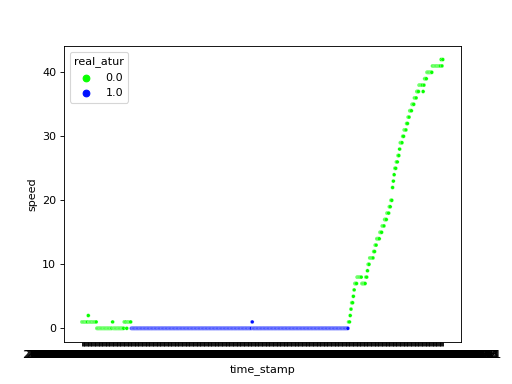

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [28]:
dft1 = dfA1.loc[6078:6538,:].copy()
realparado2(dft1);

sns.scatterplot(data = dft1, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


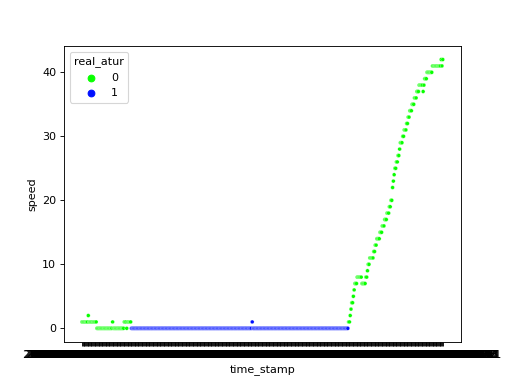

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [29]:
sns.scatterplot(data = dfA_n2.loc[6078:6538,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [71]:
[len(dft1['speed']), len(dft1.loc[dft1['speed']==1,:]), len(dft1.loc[dft1['speed']==0,:]),
len(dft1.loc[dft1['speed']==1,:])/len(dft1['speed']),
len(dft1.loc[dft1['speed']==0,:])/len(dft1['speed']),
len(dft1.loc[dft1['speed']==1,:])/len(dft1.loc[dft1['speed']==0,:])]

[461, 30, 311, 0.0650759219088937, 0.6746203904555315, 0.09646302250803858]

<IPython.core.display.Javascript object>


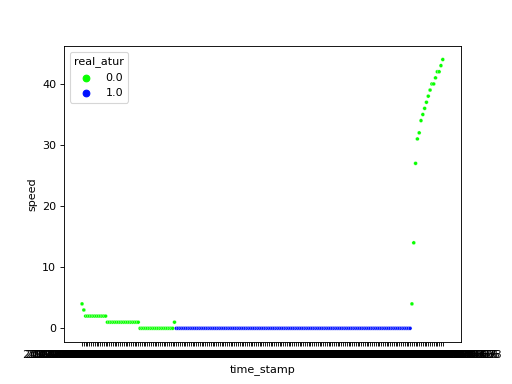

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [29]:
dft2 = dfA1.loc[11994:12193,:].copy()
realparado2(dft2);

sns.scatterplot(data = dft2, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


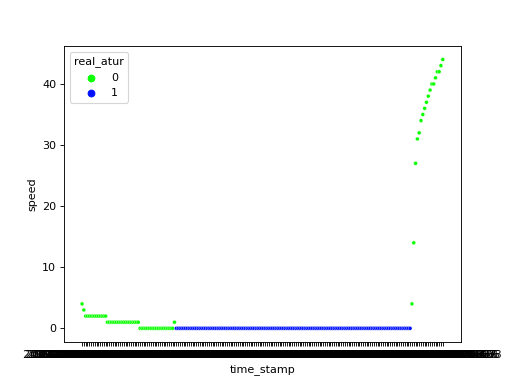

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [30]:
sns.scatterplot(data = dfA_n2.loc[11994:12193,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


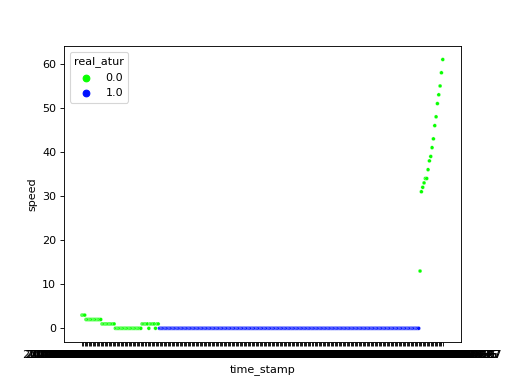

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [30]:
dft3 = dfA1.loc[38562:38832,:].copy()
realparado2(dft3);

sns.scatterplot(data = dft3, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


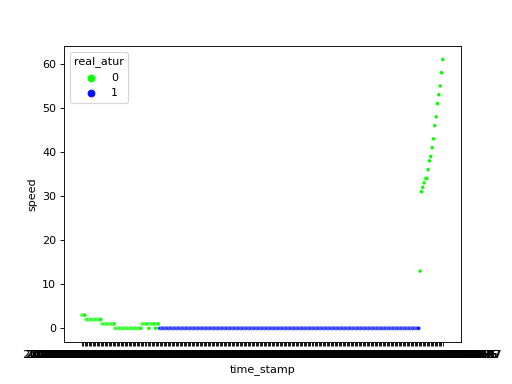

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [31]:
sns.scatterplot(data = dfA_n2.loc[38562:38832,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


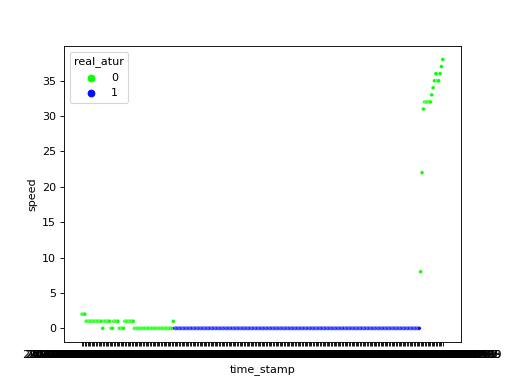

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [35]:
sns.scatterplot(data = dfA_n2.loc[50238:50499,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

# 247383600

In [28]:
dfA2=dfAmmsi.get_group(247383600)

In [29]:
realparado4(dfA2)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

4927

<IPython.core.display.Javascript object>


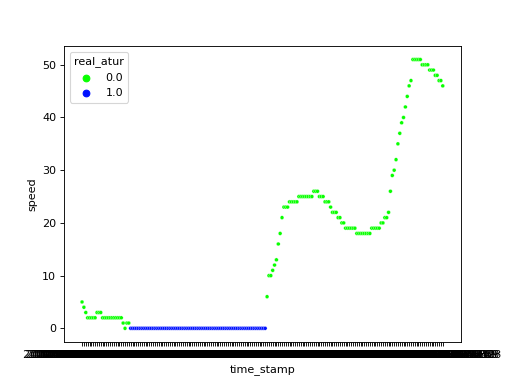

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [51]:
dft4 = dfA2.loc[9728:9921,:].copy()
realparado2(dft4);

sns.scatterplot(data = dft4, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


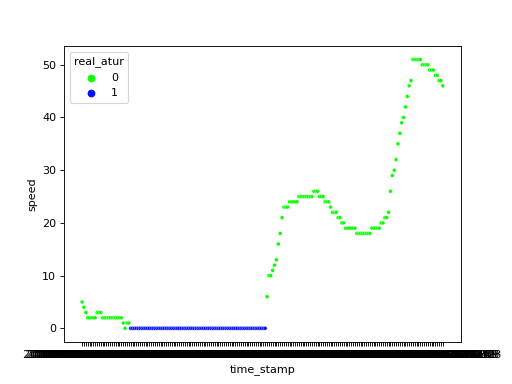

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [30]:
sns.scatterplot(data = dfA_n2.loc[9728:9921,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [69]:
[len(dft4['speed']), len(dft4.loc[dft4['speed']==1,:]), len(dft4.loc[dft4['speed']==0,:]),
len(dft4.loc[dft4['speed']==1,:])/len(dft4['speed']),
len(dft4.loc[dft4['speed']==0,:])/len(dft4['speed']),
len(dft4.loc[dft4['speed']==1,:])/len(dft4.loc[dft4['speed']==0,:])]

[194, 3, 74, 0.015463917525773196, 0.38144329896907214, 0.04054054054054054]

<IPython.core.display.Javascript object>


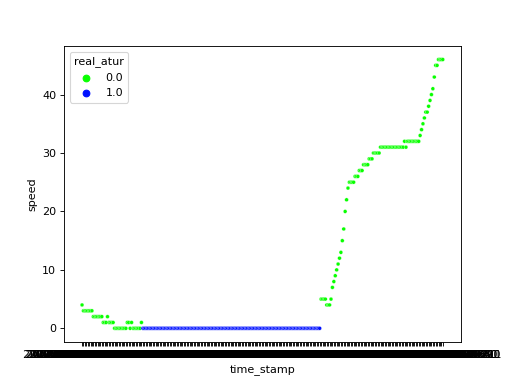

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [52]:
dft5 = dfA2.loc[20292:20547,:].copy()
realparado2(dft5);

sns.scatterplot(data = dft5, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


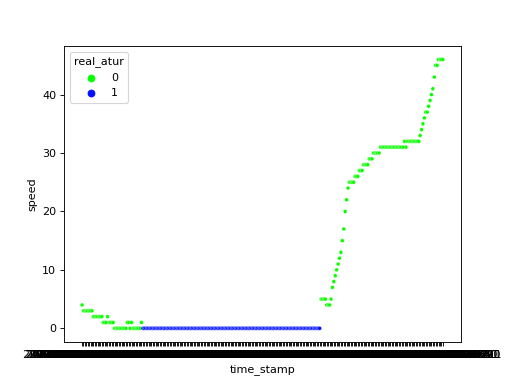

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [31]:
sns.scatterplot(data = dfA_n2.loc[20292:20547,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [64]:
[len(dft5['speed']), len(dft5.loc[dft5['speed']==1,:]), len(dft5.loc[dft5['speed']==0,:]),
len(dft5.loc[dft5['speed']==1,:])/len(dft5['speed']),
len(dft5.loc[dft5['speed']==0,:])/len(dft5['speed']),
len(dft5.loc[dft5['speed']==1,:])/len(dft5.loc[dft5['speed']==0,:])]

[256, 11, 142, 0.04296875, 0.5546875, 0.07746478873239436]

<IPython.core.display.Javascript object>


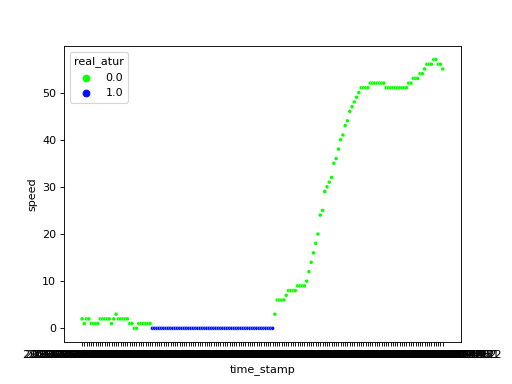

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [81]:
dft6 = dfA2.loc[39397:39557,:].copy()
realparado2(dft6);

sns.scatterplot(data = dft6, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [62]:
[len(dft6['speed']), len(dft6.loc[dft6['speed']==1,:]), len(dft6.loc[dft6['speed']==0,:]),
len(dft6.loc[dft6['speed']==1,:])/len(dft6['speed']),
len(dft6.loc[dft6['speed']==0,:])/len(dft6['speed']),
len(dft6.loc[dft6['speed']==1,:])/len(dft6.loc[dft6['speed']==0,:])]

[161, 14, 56, 0.08695652173913043, 0.34782608695652173, 0.25]

In [79]:
len(dft6.loc[dft6['real_atur']==1,:])/len(dft6['real_atur'])

0.3416149068322981

# 247219400

In [33]:
dfA3=dfAmmsi.get_group(247219400)

In [34]:
realparado4(dfA3)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

17976

<IPython.core.display.Javascript object>


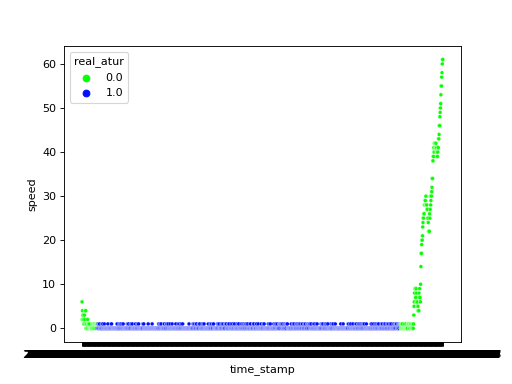

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [38]:
dft7 = dfA3.loc[1213:2582,:].copy()
realparado2(dft7);

sns.scatterplot(data = dft7, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


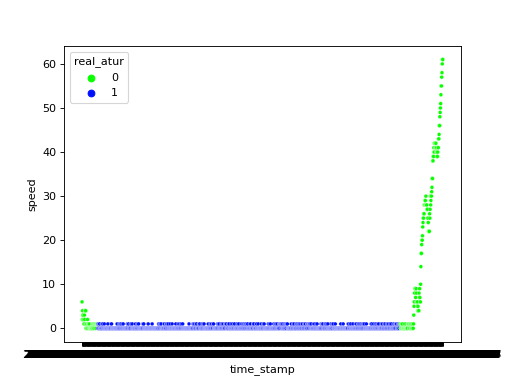

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [32]:
sns.scatterplot(data = dfA_n2.loc[1213:2582,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [67]:
[len(dft7['speed']), len(dft7.loc[dft7['speed']==1,:]), len(dft7.loc[dft7['speed']==0,:]),
len(dft7.loc[dft7['speed']==1,:])/len(dft7['speed']),
len(dft7.loc[dft7['speed']==0,:])/len(dft7['speed']),
len(dft7.loc[dft7['speed']==1,:])/len(dft7.loc[dft7['speed']==0,:])]

[1370, 293, 953, 0.21386861313868613, 0.6956204379562044, 0.3074501573976915]

<IPython.core.display.Javascript object>


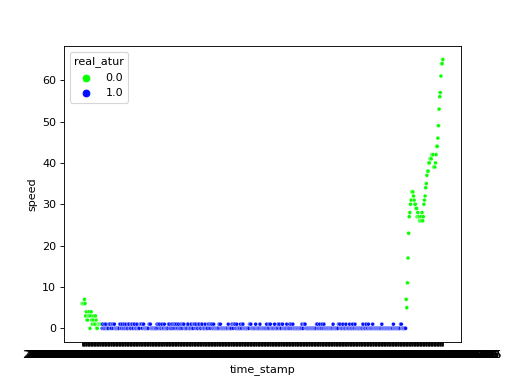

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [39]:
dft8 = dfA3.loc[6647:7239,:].copy()
realparado2(dft8);

sns.scatterplot(data = dft8, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


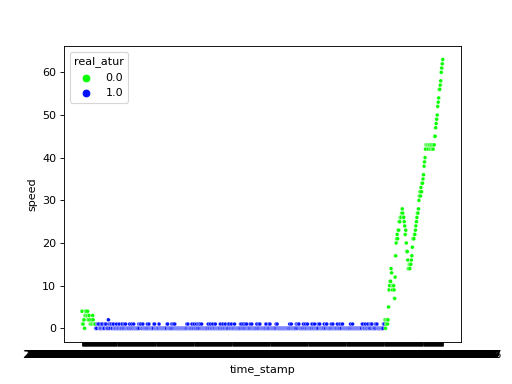

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [82]:
dft9 = dfA3.loc[8781:9493,:].copy()
realparado2(dft9);

sns.scatterplot(data = dft9, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [46]:
len(dft9['real_atur']), len(dft9.loc[dft9['real_atur']==1,:])

(713, 315)

In [47]:
315/713

0.4417952314165498

<IPython.core.display.Javascript object>


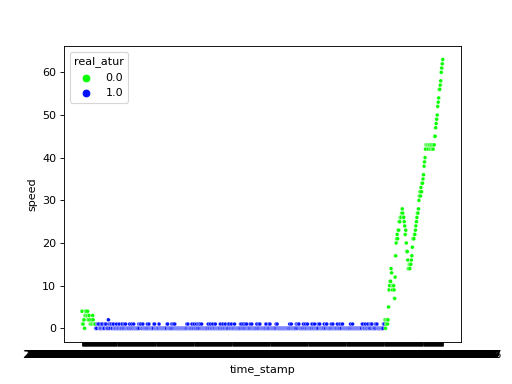

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [83]:
dft10 = dfA3.loc[8781:9493,:].copy()
realparado2(dft10);

sns.scatterplot(data = dft10, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


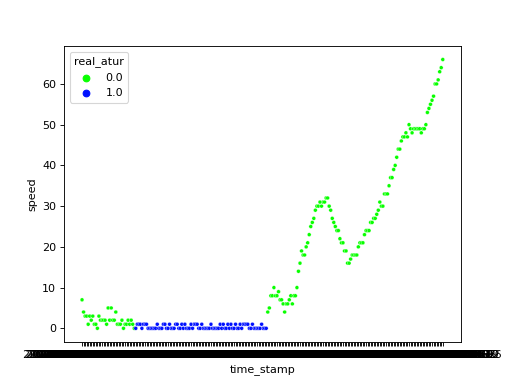

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [84]:
dft11 = dfA3.loc[14434:14669,:].copy()
realparado2(dft11);

sns.scatterplot(data = dft11, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


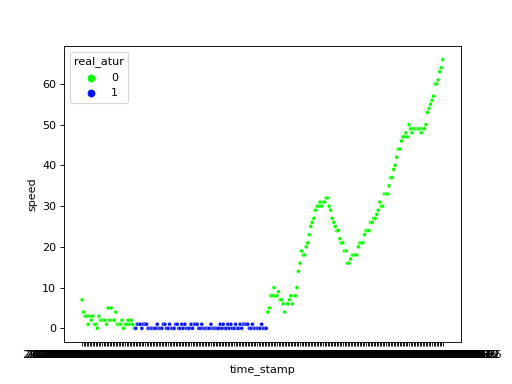

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [33]:
sns.scatterplot(data = dfA_n2.loc[14434:14669,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


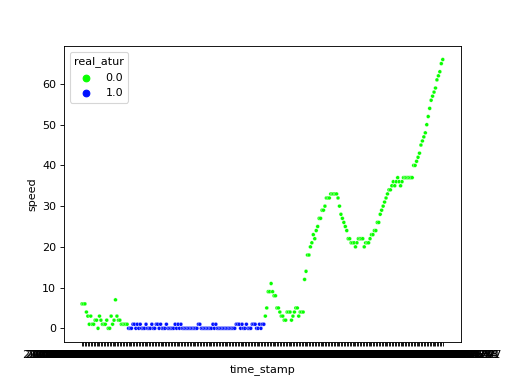

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [86]:
dft12 = dfA3.loc[19804:20052,:].copy()
realparado2(dft12);

sns.scatterplot(data = dft12, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


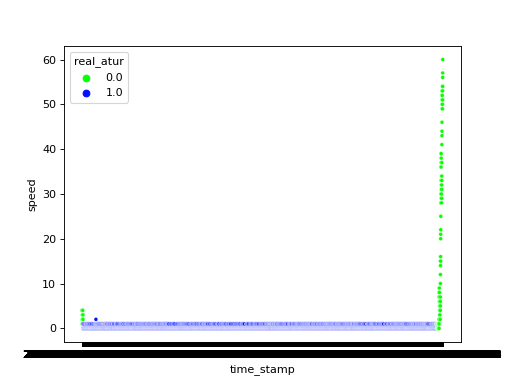

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [87]:
dft13 = dfA3.loc[21990:30438,:].copy()
realparado2(dft13);

sns.scatterplot(data = dft13, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


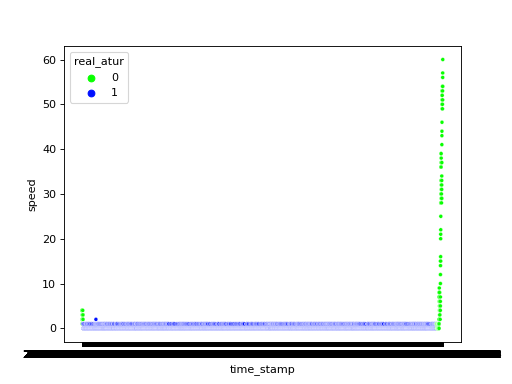

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [34]:
sns.scatterplot(data = dfA_n2.loc[21990:30438,:], x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


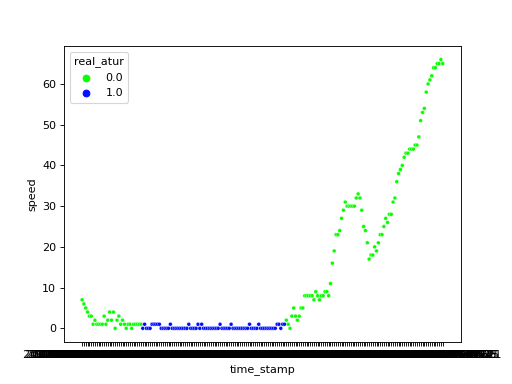

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [88]:
dft14 = dfA3.loc[33600:33796,:].copy()
realparado2(dft14);

sns.scatterplot(data = dft14, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


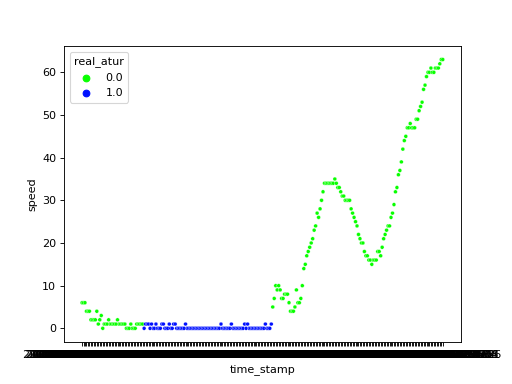

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [92]:
dft15 = dfA3.loc[38053:38297,:].copy()
realparado2(dft15);

sns.scatterplot(data = dft15, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


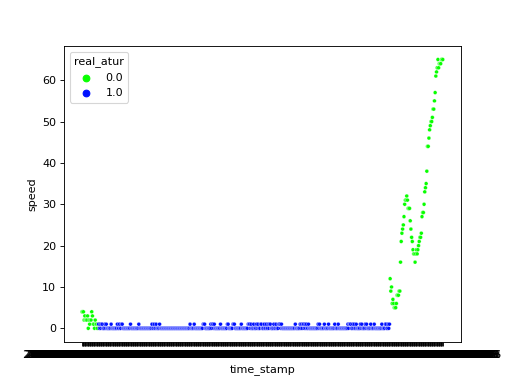

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [91]:
dft16 = dfA3.loc[39651:40172,:].copy()
realparado2(dft16);

sns.scatterplot(data = dft16, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


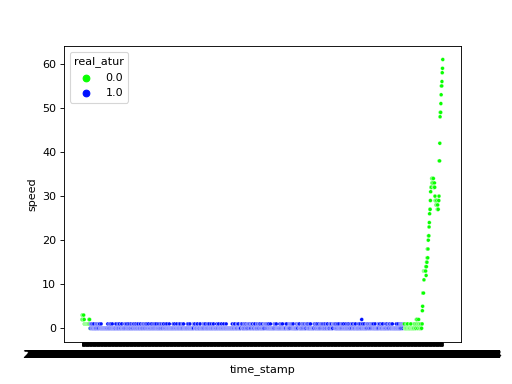

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [93]:
dft17 = dfA3.loc[42922:44266,:].copy()
realparado2(dft17);

sns.scatterplot(data = dft17, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


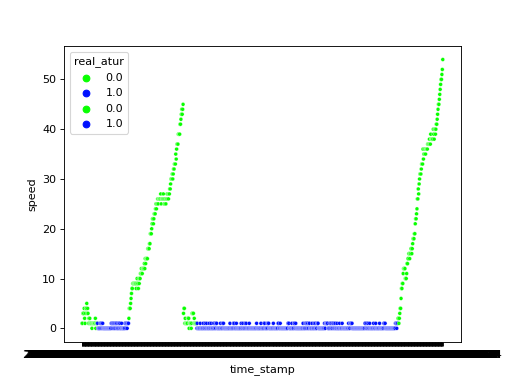

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [94]:
dft18 = dfA3.loc[47540:47775,:].copy()
realparado2(dft18);

sns.scatterplot(data = dft18, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


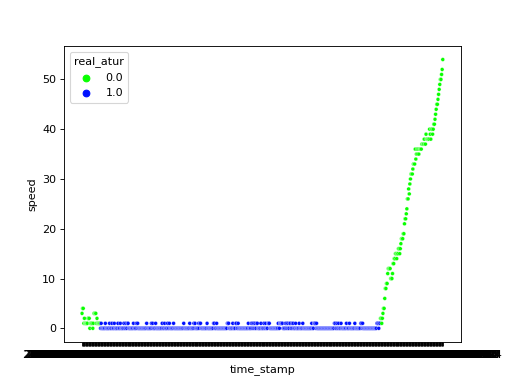

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [96]:
dft19 = dfA3.loc[50623:51226,:].copy()
realparado2(dft19);

sns.scatterplot(data = dft19, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


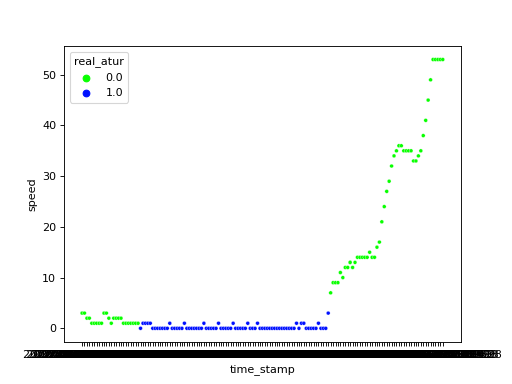

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [97]:
dft20 = dfA3.loc[56306:56455,:].copy()
realparado2(dft20);

sns.scatterplot(data = dft20, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [85]:
[len(dft11['speed']), len(dft11.loc[dft11['speed']==1,:]), len(dft11.loc[dft11['speed']==0,:]),
len(dft11.loc[dft11['speed']==1,:])/len(dft11['speed']),
len(dft11.loc[dft11['speed']==0,:])/len(dft11['speed']),
len(dft11.loc[dft11['speed']==1,:])/len(dft11.loc[dft11['speed']==0,:])]

[236, 43, 57, 0.18220338983050846, 0.24152542372881355, 0.7543859649122807]

In [61]:
[len(dft9['speed']), len(dft9.loc[dft9['speed']==1,:]), len(dft9.loc[dft9['speed']==0,:]),
len(dft9.loc[dft9['speed']==1,:])/len(dft9['speed']),
len(dft9.loc[dft9['speed']==0,:])/len(dft9['speed']),
len(dft9.loc[dft9['speed']==1,:])/len(dft9.loc[dft9['speed']==0,:])]

[713, 124, 460, 0.17391304347826086, 0.6451612903225806, 0.26956521739130435]

In [63]:
[len(dft6['speed']), len(dft6.loc[dft6['speed']==1,:]), len(dft6.loc[dft6['speed']==0,:]),
len(dft6.loc[dft6['speed']==1,:])/len(dft6['speed']),
len(dft6.loc[dft6['speed']==0,:])/len(dft6['speed']),
len(dft6.loc[dft6['speed']==1,:])/len(dft6.loc[dft6['speed']==0,:])]

[161, 14, 56, 0.08695652173913043, 0.34782608695652173, 0.25]

In [65]:
[len(dft5['speed']), len(dft5.loc[dft5['speed']==1,:]), len(dft5.loc[dft5['speed']==0,:]),
len(dft5.loc[dft5['speed']==1,:])/len(dft5['speed']),
len(dft5.loc[dft5['speed']==0,:])/len(dft5['speed']),
len(dft5.loc[dft5['speed']==1,:])/len(dft5.loc[dft5['speed']==0,:])]

[256, 11, 142, 0.04296875, 0.5546875, 0.07746478873239436]

In [68]:
[len(dft7['speed']), len(dft7.loc[dft7['speed']==1,:]), len(dft7.loc[dft7['speed']==0,:]),
len(dft7.loc[dft7['speed']==1,:])/len(dft7['speed']),
len(dft7.loc[dft7['speed']==0,:])/len(dft7['speed']),
len(dft7.loc[dft7['speed']==1,:])/len(dft7.loc[dft7['speed']==0,:])]

[1370, 293, 953, 0.21386861313868613, 0.6956204379562044, 0.3074501573976915]

In [70]:
[len(dft4['speed']), len(dft4.loc[dft4['speed']==1,:]), len(dft4.loc[dft4['speed']==0,:]),
len(dft4.loc[dft4['speed']==1,:])/len(dft4['speed']),
len(dft4.loc[dft4['speed']==0,:])/len(dft4['speed']),
len(dft4.loc[dft4['speed']==1,:])/len(dft4.loc[dft4['speed']==0,:])]

[194, 3, 74, 0.015463917525773196, 0.38144329896907214, 0.04054054054054054]

In [72]:
[len(dft1['speed']), len(dft1.loc[dft1['speed']==1,:]), len(dft1.loc[dft1['speed']==0,:]),
len(dft1.loc[dft1['speed']==1,:])/len(dft1['speed']),
len(dft1.loc[dft1['speed']==0,:])/len(dft1['speed']),
len(dft1.loc[dft1['speed']==1,:])/len(dft1.loc[dft1['speed']==0,:])]

[461, 30, 311, 0.0650759219088937, 0.6746203904555315, 0.09646302250803858]

# 247383400

In [38]:
dfA4=dfAmmsi.get_group(247383400)

In [39]:
realparado4(dfA4)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

26907

<IPython.core.display.Javascript object>


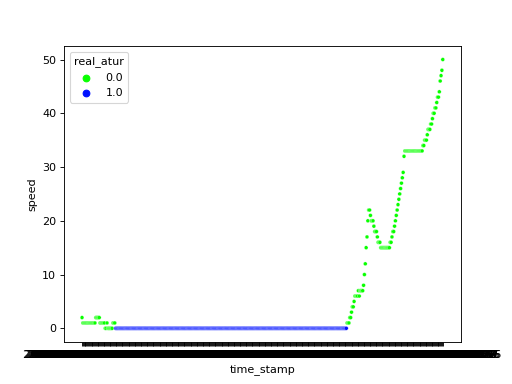

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [101]:
dft21 = dfA4.loc[7906:8598,:].copy()
realparado2(dft21);

sns.scatterplot(data = dft21, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


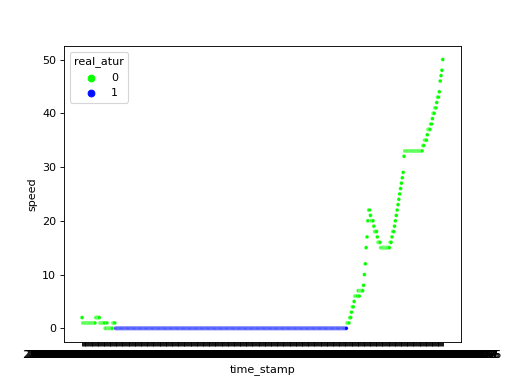

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [35]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 7906) & (dfA_n2.index <= 8598) & (dfA_n2['mmsi'] == 247383400), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


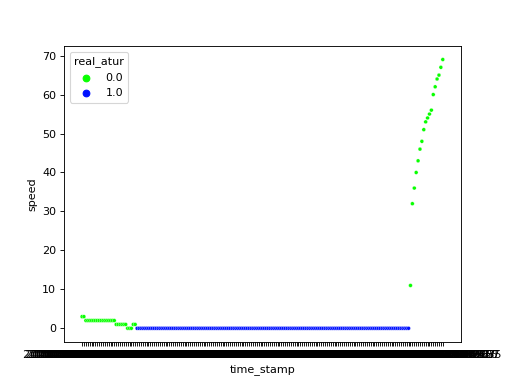

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [103]:
dft22 = dfA4.loc[48046:48236,:].copy()
realparado2(dft22)

sns.scatterplot(data = dft22, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


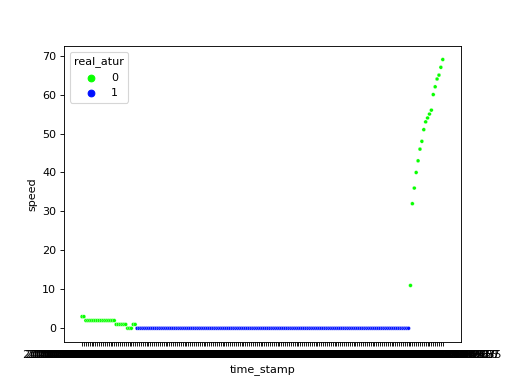

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [36]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 48046) & (dfA_n2.index <= 48236) & (dfA_n2['mmsi'] == 247383400), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

# 247243600 INTERESANTE

In [45]:
dfA5=dfAmmsi.get_group(247243600)

In [51]:
realparado4(dfA5)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

31677

<IPython.core.display.Javascript object>


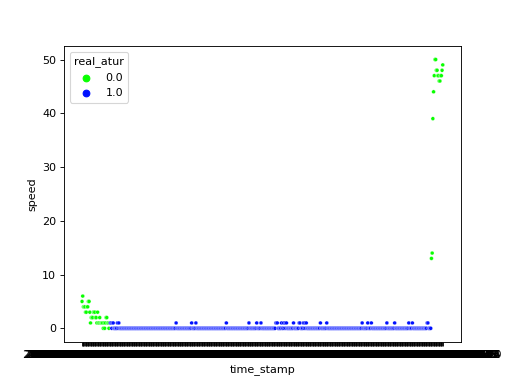

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [113]:
dft23 = dfA5.loc[5249:5759,:].copy()
realparado1(dft23)

sns.scatterplot(data = dft23, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


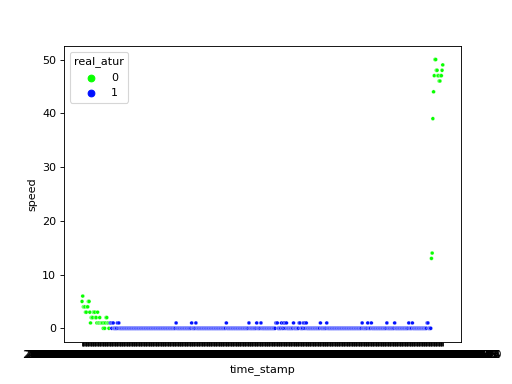

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [37]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 5249) & (dfA_n2.index <= 5759) & (dfA_n2['mmsi'] == 247243600), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [112]:
[len(dft23['speed']), len(dft23.loc[dft23['speed']==1,:]), len(dft23.loc[dft23['speed']==0,:]),
len(dft23.loc[dft23['speed']==1,:])/len(dft23['speed']),
len(dft23.loc[dft23['speed']==0,:])/len(dft23['speed']),
len(dft23.loc[dft23['speed']==1,:])/len(dft23.loc[dft23['speed']==0,:]),
len(dft23.loc[dft23['real_atur']==1,:])/len(dft23['real_atur'])]

[511,
 50,
 420,
 0.09784735812133072,
 0.821917808219178,
 0.11904761904761904,
 0.2974559686888454]

In [111]:
len(dft23.loc[dft23['real_atur']==1,:])/len(dft23['real_atur'])

0.2974559686888454

<IPython.core.display.Javascript object>


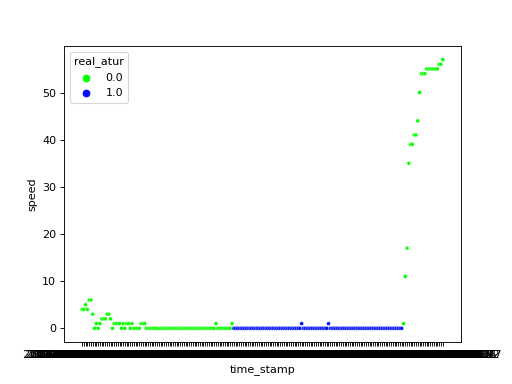

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [126]:
dft24 = dfA5.loc[8169:8658,:].copy()
realparado2(dft24)

sns.scatterplot(data = dft24, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


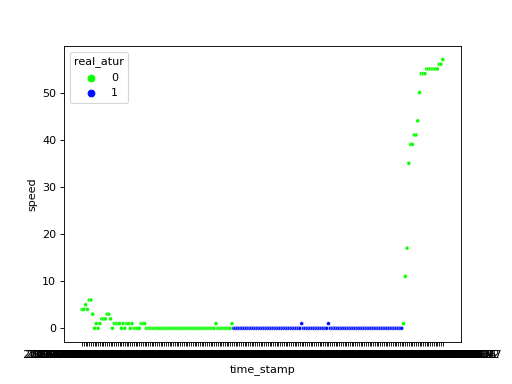

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [38]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 8169) & (dfA_n2.index <= 8658) & (dfA_n2['mmsi'] == 247243600), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [119]:
[len(dft24['speed']), len(dft24.loc[dft24['speed']==1,:]), len(dft24.loc[dft24['speed']==0,:]),
len(dft24.loc[dft24['speed']==1,:])/len(dft24['speed']),
len(dft24.loc[dft24['speed']==0,:])/len(dft24['speed']),
len(dft24.loc[dft24['speed']==1,:])/len(dft24.loc[dft24['speed']==0,:]),
len(dft24.loc[dft24['real_atur']==1,:])/len(dft24['real_atur'])]

[203,
 18,
 150,
 0.08866995073891626,
 0.7389162561576355,
 0.12,
 0.7881773399014779]

<IPython.core.display.Javascript object>


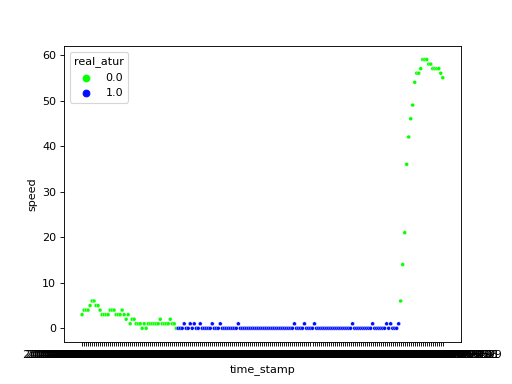

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [127]:
dft25 = dfA5.loc[11529:11709,:].copy()
realparado2(dft25)

sns.scatterplot(data = dft25, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [128]:
[len(dft25['speed']), len(dft25.loc[dft25['speed']==1,:]), len(dft25.loc[dft25['speed']==0,:]),
len(dft25.loc[dft25['speed']==1,:])/len(dft25['speed']),
len(dft25.loc[dft25['speed']==0,:])/len(dft25['speed']),
len(dft24.loc[dft24['speed']==1,:])/len(dft24.loc[dft24['speed']==0,:]),
len(dft25.loc[dft25['real_atur']==1,:])/len(dft25['real_atur'])]

[181,
 32,
 99,
 0.17679558011049723,
 0.5469613259668509,
 0.12,
 0.6132596685082873]

In [130]:
comp(dft25)

R1


[181,
 32,
 99,
 0.17679558011049723,
 0.5469613259668509,
 0.32323232323232326,
 0.6132596685082873]

<IPython.core.display.Javascript object>


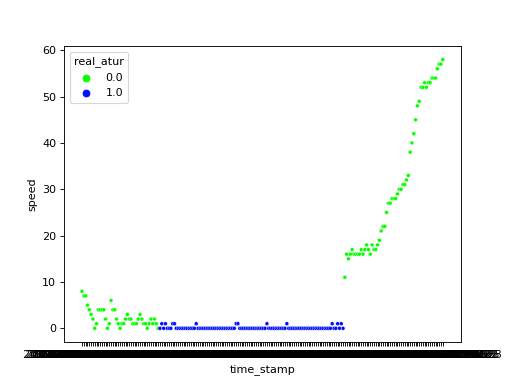

R1


[200, 25, 95, 0.125, 0.475, 0.2631578947368421, 0.51]

In [134]:
dft26 = dfA5.loc[15985:16184,:].copy()
realparado2(dft26)

sns.scatterplot(data = dft26, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft26)

<IPython.core.display.Javascript object>


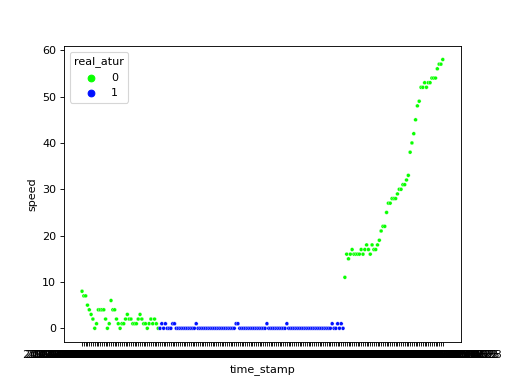

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [39]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 15985) & (dfA_n2.index <= 16184) & (dfA_n2['mmsi'] == 247243600), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


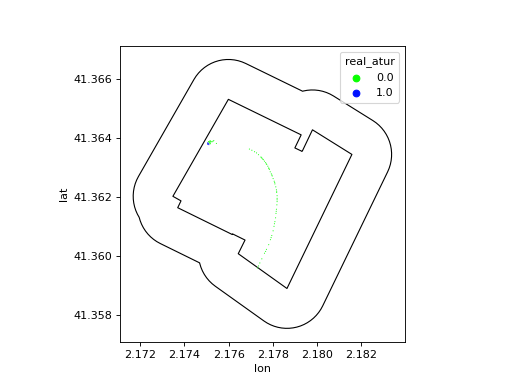

<AxesSubplot:xlabel='lon', ylabel='lat'>

In [135]:
fig, ax = plt.subplots()
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')
dm_map.plot(ax = ax, fc = 'none', ec = 'black')
sns.scatterplot(data = dft26, x = 'lon',y = 'lat', s = 1, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


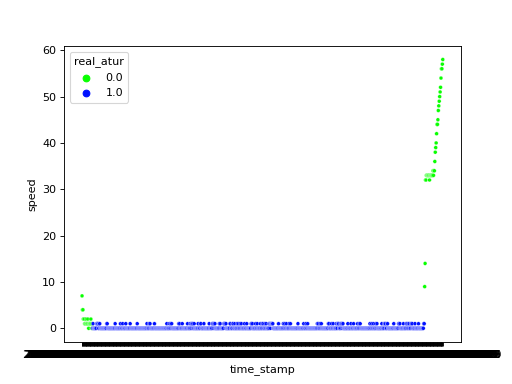

R1


[818,
 151,
 616,
 0.1845965770171149,
 0.7530562347188264,
 0.24512987012987014,
 0.9193154034229829]

In [136]:
dft27 = dfA5.loc[20990:21807,:].copy()
realparado2(dft27)

sns.scatterplot(data = dft27, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft27)

<IPython.core.display.Javascript object>


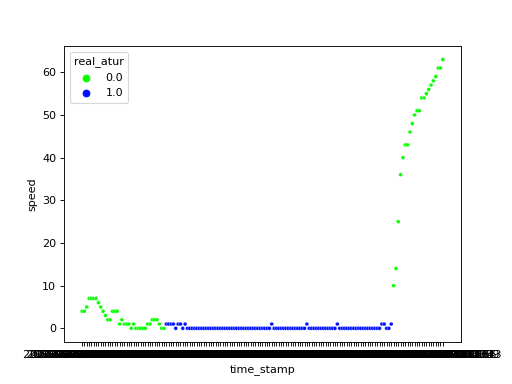

R1


[155,
 21,
 92,
 0.13548387096774195,
 0.5935483870967742,
 0.22826086956521738,
 0.6258064516129033]

In [57]:
dft28 = dfA5.loc[32112:32266,:].copy()
realparado2(dft28)

sns.scatterplot(data = dft28, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft28)

<IPython.core.display.Javascript object>


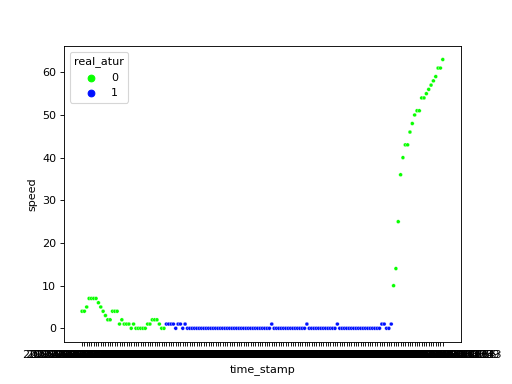

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [40]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 32112) & (dfA_n2.index <= 32266) & (dfA_n2['mmsi'] == 247243600), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


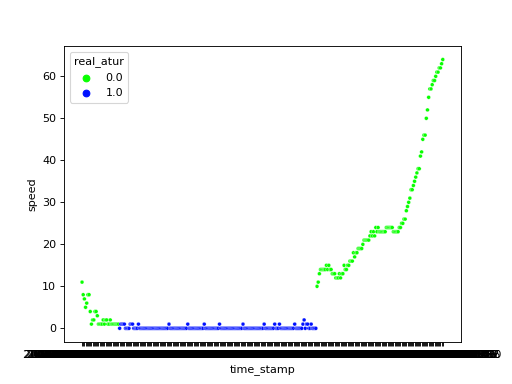

R


[308,
 36,
 146,
 0.11688311688311688,
 0.474025974025974,
 0.2465753424657534,
 0.5454545454545454]

In [141]:
dft29 = dfA5.loc[36838:37145,:].copy()
realparado2(dft29)

sns.scatterplot(data = dft29, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft29)

<IPython.core.display.Javascript object>


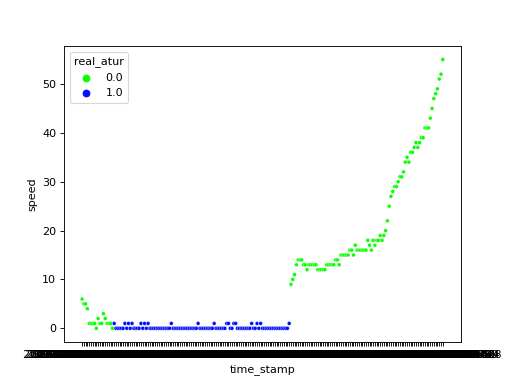

R1


[203,
 27,
 83,
 0.1330049261083744,
 0.4088669950738916,
 0.3253012048192771,
 0.4876847290640394]

In [144]:
dft30 = dfA5.loc[38932:39134,:].copy()
realparado2(dft30)

sns.scatterplot(data = dft30, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft30)

<IPython.core.display.Javascript object>


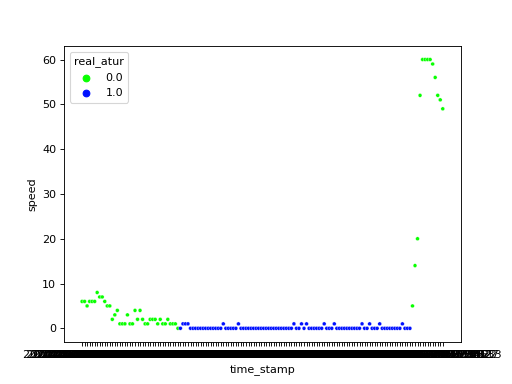

R1


[144,
 27,
 79,
 0.1875,
 0.5486111111111112,
 0.34177215189873417,
 0.6388888888888888]

In [145]:
dft31 = dfA5.loc[41561:41704,:].copy()
realparado2(dft31)

sns.scatterplot(data = dft31, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft31)

<IPython.core.display.Javascript object>


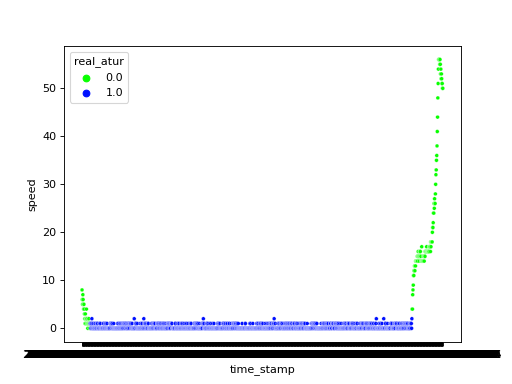

R1


[1321,
 377,
 804,
 0.2853898561695685,
 0.6086298258894777,
 0.4689054726368159,
 0.8917486752460257]

In [158]:
dft32 = dfA5.loc[45266:46586,:].copy()
realparado2(dft32)

sns.scatterplot(data = dft32, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft32)

In [152]:
dft32['speed_window'] = dft32['speed'].rolling(window=5).mean()

<IPython.core.display.Javascript object>


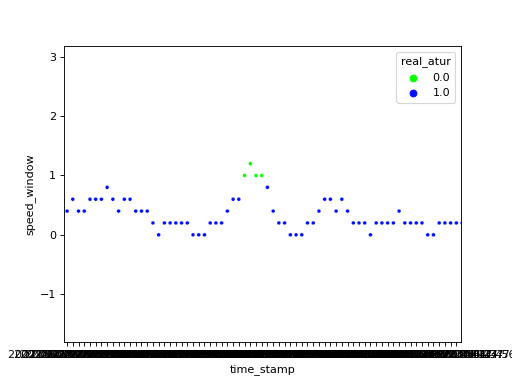

<AxesSubplot:xlabel='time_stamp', ylabel='speed_window'>

In [153]:
sns.scatterplot(data = dft32, x = 'time_stamp',y = 'speed_window', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


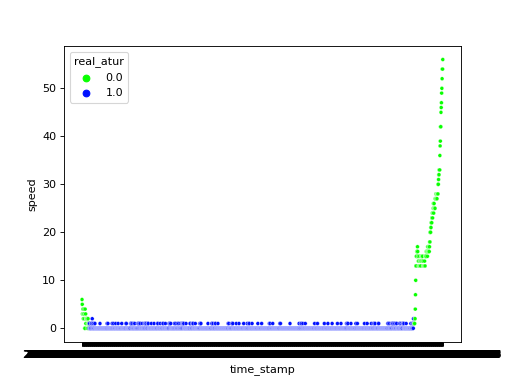

R


[1628,
 159,
 1317,
 0.09766584766584767,
 0.808968058968059,
 0.12072892938496584,
 0.9004914004914005]

In [58]:
dft33 = dfA5.loc[48335:49962,:].copy()
realparado2(dft33)

sns.scatterplot(data = dft33, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft33)

<IPython.core.display.Javascript object>


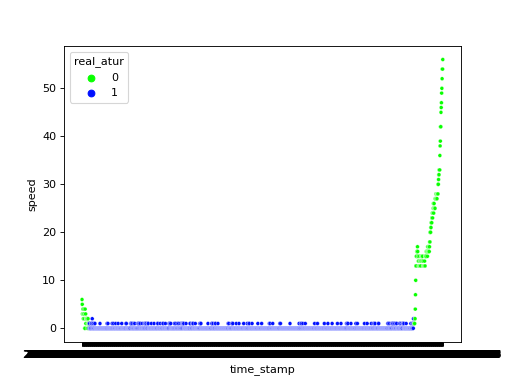

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [41]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 48335) & (dfA_n2.index <= 49962) & (dfA_n2['mmsi'] == 247243600), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

<IPython.core.display.Javascript object>


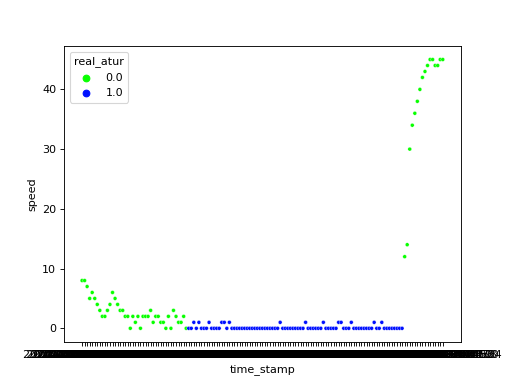

R1


[143,
 20,
 76,
 0.13986013986013987,
 0.5314685314685315,
 0.2631578947368421,
 0.5944055944055944]

In [161]:
dft34 = dfA5.loc[52828:52970,:].copy()
realparado2(dft34)

sns.scatterplot(data = dft34, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft34)

<IPython.core.display.Javascript object>


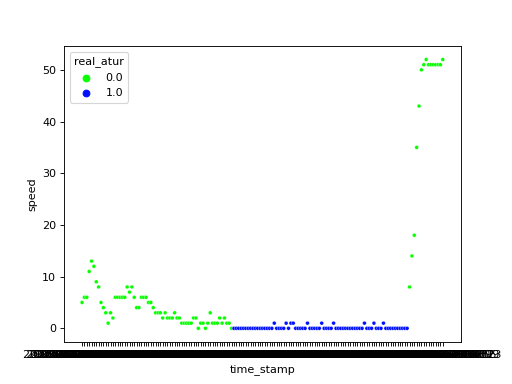

R1


[153,
 25,
 67,
 0.16339869281045752,
 0.43790849673202614,
 0.373134328358209,
 0.48366013071895425]

In [162]:
dft35 = dfA5.loc[57168:57320,:].copy()
realparado2(dft35)

sns.scatterplot(data = dft35, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft35)

# 247383300

In [163]:
dfA6=dfAmmsi.get_group(247383300)

<IPython.core.display.Javascript object>


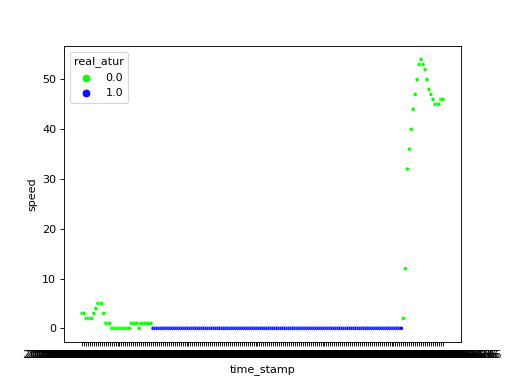

R


[184,
 13,
 138,
 0.07065217391304347,
 0.75,
 0.09420289855072464,
 0.6902173913043478]

In [165]:
dft36 = dfA6.loc[7450:7633,:].copy()
realparado2(dft36)

sns.scatterplot(data = dft36, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft36)

<IPython.core.display.Javascript object>


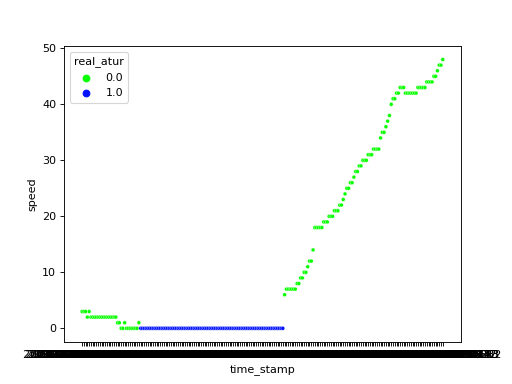

R


[204,
 4,
 90,
 0.0196078431372549,
 0.4411764705882353,
 0.044444444444444446,
 0.39705882352941174]

In [166]:
dft37 = dfA6.loc[20749:21904,:].copy()
realparado2(dft37)

sns.scatterplot(data = dft37, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft37)

<IPython.core.display.Javascript object>


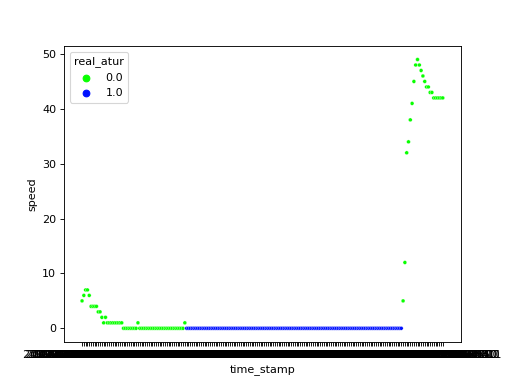

R


[201,
 12,
 153,
 0.05970149253731343,
 0.7611940298507462,
 0.0784313725490196,
 0.5970149253731343]

In [167]:
dft38 = dfA6.loc[44976:45176,:].copy()
realparado2(dft38)

sns.scatterplot(data = dft38, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft38)

# 209115000

In [69]:
dfA7=dfAmmsi.get_group(209115000)

In [61]:
realparado4(dfA7)
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

32822

<IPython.core.display.Javascript object>


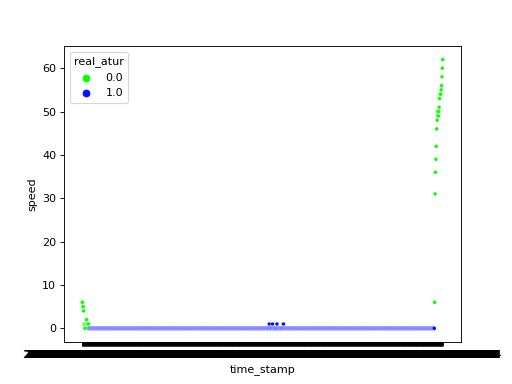

R


[893,
 12,
 854,
 0.013437849944008958,
 0.9563269876819709,
 0.01405152224824356,
 0.9574468085106383]

In [71]:
dft39 = dfA7.loc[10057:10949,:].copy()
realparado2(dft39)

sns.scatterplot(data = dft39, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft39)

<IPython.core.display.Javascript object>


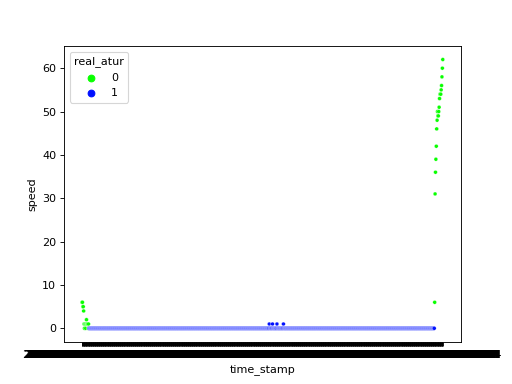

<AxesSubplot:xlabel='time_stamp', ylabel='speed'>

In [70]:
sns.scatterplot(data = dfA_n2.loc[(dfA_n2.index >= 10057) & (dfA_n2.index <= 10949) & (dfA_n2['mmsi'] == 209115000), :]
, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')

In [68]:
dft40 = dfA7.loc[10057:10949,:].copy()
realparado2(dft40)

sns.scatterplot(data = dft40, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft40)

NameError: name 'dfA7' is not defined

# 210117000

In [43]:
dfA8=dfAmmsi.get_group(210117000)

In [53]:
len (dfA8)

114

In [54]:
dfA8.head(114)

time_stamp       mmsi  status   turn  speed      lon  \
40179  2022-06-20 19:07:42  210117000       5    0.0   51.0  2.17706   
40180  2022-06-20 19:07:52  210117000       5    0.0   50.0  2.17726   
40181  2022-06-20 19:08:00  210117000       5 -127.0   49.0  2.17743   
40182  2022-06-20 19:08:11  210117000       5 -127.0   49.0  2.17763   
40183  2022-06-20 19:08:22  210117000       5 -127.0   47.0  2.17786   
...                    ...        ...     ...    ...    ...      ...   
40288  2022-06-20 21:34:22  210117000       5  127.0   55.0  2.17782   
40289  2022-06-20 21:34:32  210117000       5    0.0   54.0  2.17772   
40290  2022-06-20 21:34:42  210117000       5    0.0   55.0  2.17758   
40291  2022-06-20 21:34:53  210117000       5    0.0   55.0  2.17739   
40292  2022-06-20 21:35:03  210117000       5    0.0   57.0  2.17722   

            lat  course  heading         day  ... draught  to_bow  to_stern  \
40179  41.35813    37.8     40.0  2022-06-20  ...     4.2   116.0      23.0   
40180  41.35831    39.0     38.0  2022-06-20  ...     4.2   116.0      23.0   
40181  41.35847    39.6     37.0  2022-06-20  ...     4.2   116.0      23.0   
40182  41.35865    39.1     34.0  2022-06-20  ...     4.2   116.0      23.0   
40183  41.35886    38.7     30.0  2022-06-20  ...     4.2   116.0      23.0   
...         ...     ...      ...         ...  ...     ...     ...       ...   
40288  41.35910   195.5    209.0  2022-06-20  ...     4.2   116.0      23.0   
40289  41.35886   202.7    210.0  2022-06-20  ...     4.2   116.0      23.0   
40290  41.35864   205.5    211.0  2022-06-20  ...     4.2   116.0      23.0   
40291  41.35837   207.4    210.0  2022-06-20  ...     4.2   116.0      23.0   
40292  41.35813   206.7    210.0  2022-06-20  ...     4.2   116.0      23.0   

       to_starboard  to_port      imo  zone  aturat  entsort  real_atur  
40179          13.0      4.0  7802794     2     NaN      NaN          0  
40180          13.0      4.0  7802794     2     NaN      NaN          0  
40181          13.0      4.0  7802794     2     NaN      NaN          0  
40182          13.0      4.0  7802794     2     NaN      NaN          0  
40183          13.0      4.0  7802794     2     NaN      NaN          0  
...             ...      ...      ...   ...     ...      ...        ...  
40288          13.0      4.0  7802794     2     NaN     sort          0  
40289          13.0      4.0  7802794     2     NaN      NaN          0  
40290          13.0      4.0  7802794     2     NaN      NaN          0  
40291          13.0      4.0  7802794     2     NaN      NaN          0  
40292          13.0      4.0  7802794     2     NaN      NaN          0  

[114 rows x 22 columns]

<IPython.core.display.Javascript object>


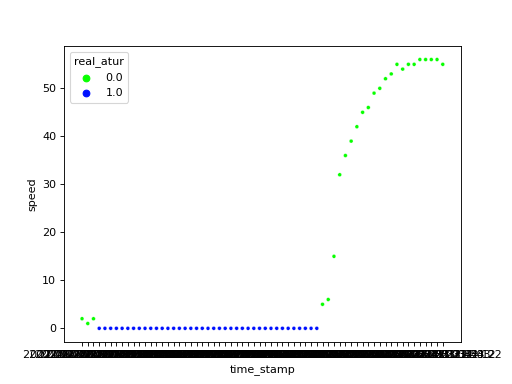

R


[64, 1, 39, 0.015625, 0.609375, 0.02564102564102564, 0.609375]

In [67]:
dft40 = dfA8.loc[40225:40288,:].copy()
realparado(dft40)

sns.scatterplot(data = dft40, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft40)

In [48]:
dft40.loc[dft40['speed']==1,:]

time_stamp       mmsi  status  turn  speed      lon       lat  \
40226  2022-06-20 19:20:20  210117000       5   0.0    1.0  2.17849  41.36424   

       course  heading         day  ... draught  to_bow  to_stern  \
40226    64.2    299.0  2022-06-20  ...     4.2   116.0      23.0   

       to_starboard  to_port      imo  zone  aturat  entsort  real_atur  
40226          13.0      4.0  7802794     0     NaN      NaN        0.0  

[1 rows x 22 columns]

In [58]:
pd.to_datetime(dft40.loc[dft40['speed']==0,['time_stamp']].iloc[-1]) - pd.to_datetime(dft40.loc[dft40['speed']==0,['time_stamp']].iloc[0])

time_stamp   0 days 01:54:03
dtype: timedelta64[ns]

<IPython.core.display.Javascript object>


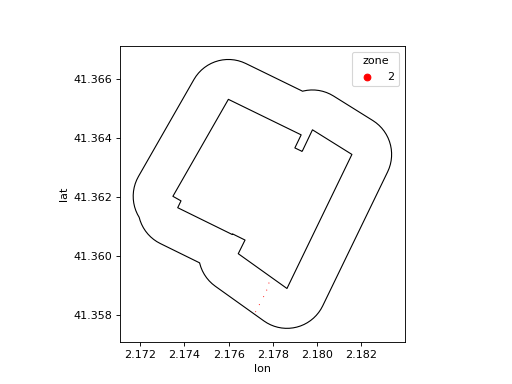

<AxesSubplot:xlabel='lon', ylabel='lat'>

In [57]:
fig, ax = plt.subplots()
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')
dm_map.plot(ax = ax, fc = 'none', ec = 'black')
sns.scatterplot(data = dfA8.loc[40288:40292], x = 'lon',y = 'lat', s = 1, hue = 'zone', palette = 'hsv')

In [60]:
df=dft40.copy()
df['parado'] = (df['speed'] == 0)
df['consecutivos'] = (df['parado'] != df['parado'].shift()).cumsum()
dif = df.loc[df['speed']==0].groupby('consecutivos')
grupos = dif['time_stamp'].apply(lambda x: pd.to_datetime(x.iloc[-1]) - pd.to_datetime(x.iloc[0]))
grupos_filtrados = grupos[grupos >= pd.Timedelta(minutes = 10)]
indices = grupos_filtrados.index.values
for consecutivo in indices:
    df.loc[df['consecutivos'] == consecutivo, 'real_atur'] = 1

<IPython.core.display.Javascript object>


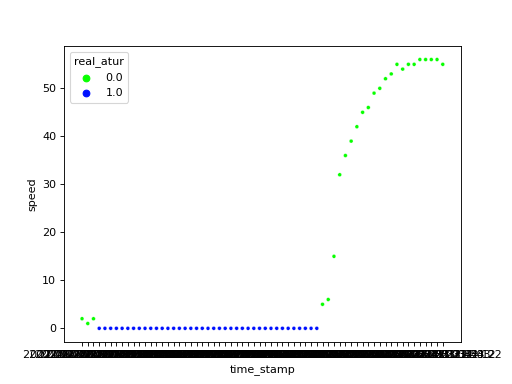

R1


[64, 1, 39, 0.015625, 0.609375, 0.02564102564102564, 0.0]

In [61]:
sns.scatterplot(data = df, x = 'time_stamp',y = 'speed', s = 12, hue = 'real_atur', palette = 'hsv')
comp(dft40)

# Final TEST

New values

In [27]:
dfAmmsi['real_atur'].describe()

count      mean       std  min  25%  50%  75%  max
mmsi                                                           
209115000   1673.0  0.662881  0.472867  0.0  0.0  1.0  1.0  1.0
210117000    114.0  0.342105  0.476509  0.0  0.0  0.0  1.0  1.0
247219400  16251.0  0.802966  0.397770  0.0  1.0  1.0  1.0  1.0
247243600   7499.0  0.636352  0.481081  0.0  0.0  1.0  1.0  1.0
247383300   7102.0  0.545199  0.497988  0.0  0.0  1.0  1.0  1.0
247383400  12831.0  0.696049  0.459980  0.0  0.0  1.0  1.0  1.0
247383500   5890.0  0.342445  0.474568  0.0  0.0  0.0  1.0  1.0
247383600   5979.0  0.486703  0.499865  0.0  0.0  0.0  1.0  1.0

In [28]:
dfAmmsi['real_atur'].apply(lambda x: (x == 1).sum())

mmsi
209115000     1109
210117000       39
247219400    13049
247243600     4772
247383300     3872
247383400     8931
247383500     2017
247383600     2910
Name: real_atur, dtype: int64

Old values

In [72]:
dfAmmsi['real_atur'].describe()

count      mean       std  min  25%  50%  75%  max
mmsi                                                           
209115000   1673.0  0.684399  0.464894  0.0  0.0  1.0  1.0  1.0
210117000    114.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
247219400  16251.0  0.802966  0.397770  0.0  1.0  1.0  1.0  1.0
247243600   7499.0  0.636352  0.481081  0.0  0.0  1.0  1.0  1.0
247383300   7102.0  0.545199  0.497988  0.0  0.0  1.0  1.0  1.0
247383400  12831.0  0.696049  0.459980  0.0  0.0  1.0  1.0  1.0
247383500   5890.0  0.342445  0.474568  0.0  0.0  0.0  1.0  1.0
247383600   5979.0  0.486703  0.499865  0.0  0.0  0.0  1.0  1.0

In [73]:
dfAmmsi['real_atur'].apply(lambda x: (x == 1).sum())

mmsi
209115000     1145
210117000        0
247219400    13049
247243600     4772
247383300     3872
247383400     8931
247383500     2017
247383600     2910
Name: real_atur, dtype: int64